In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,"../")

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

import core.utils_disco
from core.dataloader import CLEVR_train, collate_boxes

In [4]:
train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5t.txt')
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, collate_fn=collate_boxes)

Initialised..... 250  files...


In [5]:
train_iter = iter(train_loader)

feed_dict_q_, feed_dict_k_, metadata_ = next(train_iter)
    
# feed_dict_q_["images"] = feed_dict_q_["images"].cuda()
# feed_dict_k_["images"] = feed_dict_k_["images"].cuda()

../core/utils_disco.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


In [6]:
feed_dict_ = feed_dict_k_

In [7]:
import matplotlib.pyplot as plt
import cv2

def draw_bounding_box(image, bboxes):
    
    num_obj= bboxes.size(0)
    fig = plt.figure(figsize=(8,8*num_obj))
    
    axes = []
    for o in range(num_obj):
        ax = (fig.add_subplot(1,num_obj,o+1))
        axes.append(ax)
        box = bboxes[o]
        x1,y1,x2,y2 = box
        x1 = int(x1.item()); x2 = int(x2.item()); y1 = int(y1.item()); y2 = int(y2.item())
        ax.title.set_text("x1:{} , x2:{} , y1:{} , y2:{}".format(x1,x2,y1,y2))
        img = cv2.rectangle(image.copy(),(x1,y1),(x2,y2),(0,255,0),2)
        plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


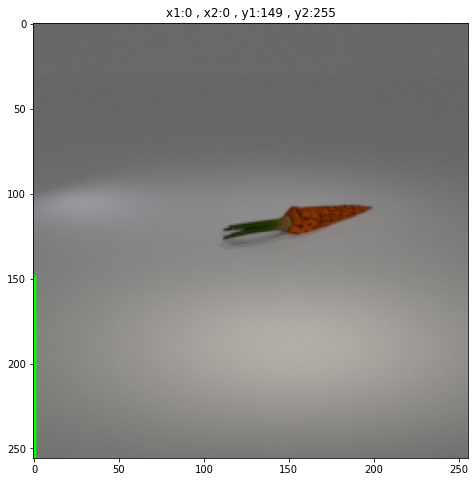

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


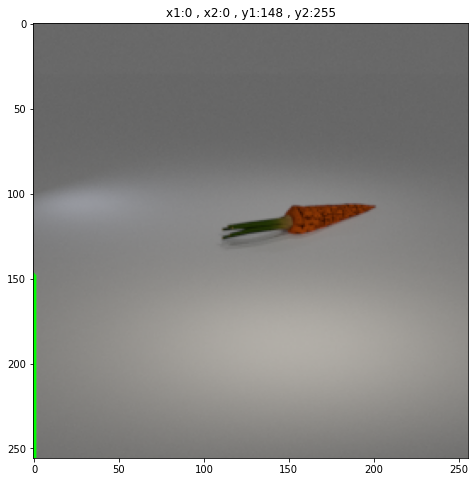

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


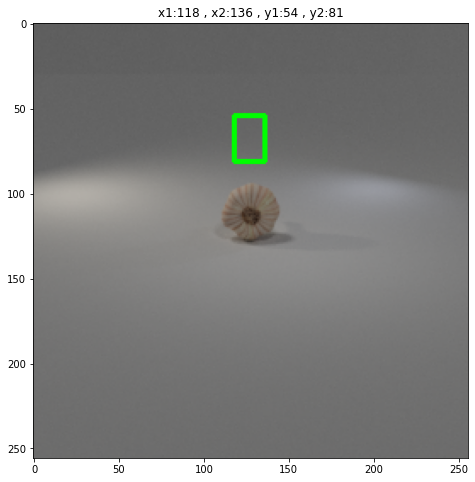

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


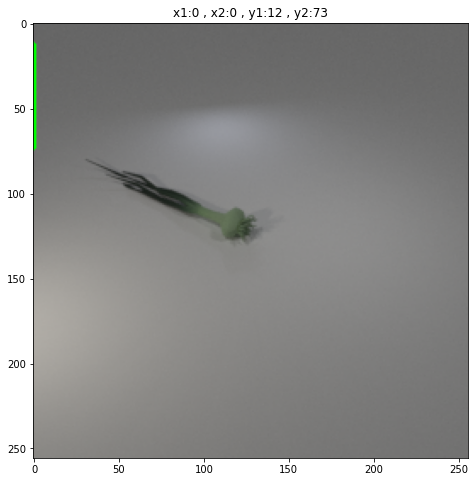

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


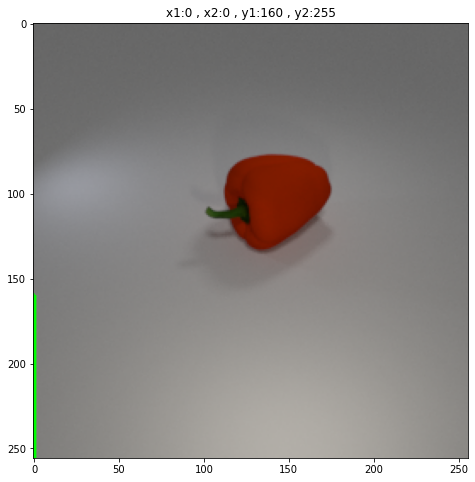

In [8]:
images = feed_dict_["images"]
objects = feed_dict_["objects_boxes"]
objects_length = feed_dict_["objects"]
num_batch = images.size(0)

objects_index = 0
for i in range(num_batch):
    box = objects[objects_index:objects_index + objects_length[i].item()].cpu()
    objects_index += objects_length[i].item() 
    
    draw_bounding_box(images[i].permute(1,2,0).cpu().numpy(), box)
    plt.show()

In [46]:
import os
data  = []
root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5t.txt'
with open(root_dir) as f:
    lines = f.readlines()

    for line in lines:
        data.append(line.split()[0])
        

all_files = [os.path.join(os.path.dirname(root_dir),f) for f in data if f.endswith('.p')]

In [47]:
all_files[1]

'/home/mprabhud/dataset/clevr_lang/npys/ab_1/CLEVR_new_000011.p'

In [48]:
import pickle
scene_path = all_files[1]
data = pickle.load(open(scene_path, "rb"))

In [132]:

import collections, os, io
from PIL import Image
import torch
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Dataset
import random
import pickle
import core.utils_data as utils_disco
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [133]:
query_camX_T_origin = torch.as_tensor(data['origin_T_camXs_raw'][0]).reshape(1,4,4)
print(query_camX_T_origin)
print(query_camX_T_origin.shape)
origin_T_camX_target = utils_disco.safe_inverse(torch.as_tensor(data['origin_T_camXs_raw'][1]).reshape(1, 4, 4))
print(origin_T_camX_target)
print(origin_T_camX_target.shape)
viewpoints = torch.matmul(query_camX_T_origin, origin_T_camX_target)
print(viewpoints.shape)

tensor([[[  1.0000,   0.0000,   0.0000,  -0.0000],
         [  0.0000,   0.9397,   0.3420,  -4.4463],
         [  0.0000,  -0.3420,   0.9397, -12.2160],
         [  0.0000,   0.0000,   0.0000,   1.0000]]])
torch.Size([1, 4, 4])
tensor([[[ 5.0000e-01,  0.0000e+00,  8.6603e-01, -0.0000e+00],
         [ 2.9620e-01,  9.3969e-01, -1.7101e-01,  2.3842e-07],
         [-8.1380e-01,  3.4202e-01,  4.6985e-01,  1.3000e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])
torch.Size([1, 4, 4])
torch.Size([1, 4, 4])


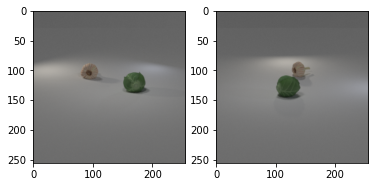

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline
f, axarr = plt.subplots(1,2)
for row in range(1):
    for col in range(2):
        axarr[col].imshow(data['rgb_camXs_raw'][2*row + col,:,:,:3])

In [135]:
rx, ry, rz = utils_disco.rotm2eul(viewpoints)
rx, ry, rz = rx.unsqueeze(1), ry.unsqueeze(1), rz.unsqueeze(1)
xyz = viewpoints[:, :3, -1]


view_vector = [xyz, torch.cos(rx), torch.sin(rx), torch.cos(rz), torch.sin(rz)]
rel_viewpoint = torch.cat(view_vector, dim=-1)

In [136]:
viewpoints

tensor([[[ 0.5000,  0.0000,  0.8660,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  0.0000],
         [-0.8660,  0.0000,  0.5000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])

In [137]:
utils_disco.safe_inverse(viewpoints)

tensor([[[ 0.5000,  0.0000, -0.8660, -0.0000],
         [ 0.0000,  1.0000,  0.0000, -0.0000],
         [ 0.8660,  0.0000,  0.5000, -0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])

In [138]:
xyz

tensor([[0., 0., 0.]])

In [139]:
rel_viewpoint

tensor([[0., 0., 0., 1., 0., 1., 0.]])

In [140]:
images = torch.as_tensor(data['rgb_camXs_raw']).permute(0,3,1,2)/255.
_, _, H_orig, W_orig = images.shape
query_image, key_image = images[0,:3,:,:], images[1,:3,:,:]

In [141]:
H_orig, W_orig

(256, 256)

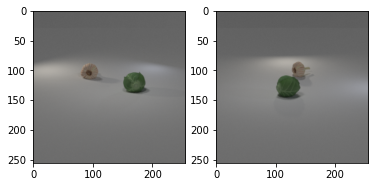

In [142]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(query_image.permute(1,2,0))
axarr[1].imshow(key_image.permute(1,2,0))

In [143]:
tree_path = data['tree_seq_filename'].replace("shamitl","mprabhud")
tree_path = tree_path.replace("datasets","dataset")

tree_file = pickle.load(open(os.path.join(tree_path),"rb"))

In [144]:
N = 2
do_shape = True
do_color = False
do_material = False
do_style = False
do_style_content = False

def trees_rearrange(trees):
    updated_trees =[]
    all_bboxes = []
    all_scores = []
    all_classes_list = []
    for tree in trees:
        tree,boxes,_,all_classes = bbox_rearrange(tree,boxes=[],classes={},all_classes=[])
        if do_shape:
            classes = [class_val["shape"] for class_val  in all_classes]
        elif do_color:
            classes = [class_val["color"] for class_val  in all_classes]
        elif do_material:
            classes = [class_val["material"] for class_val  in all_classes]
        elif do_style:
            classes = [class_val["color"]+"_"+ class_val["material"] for class_val  in all_classes]
        elif do_style_content:
            classes = [class_val["shape"]+"/"+class_val["color"]+"_"+ class_val["material"] for class_val  in all_classes]
        elif do_color_content:            
            classes = [class_val["shape"]+"/"+class_val["color"] for class_val  in all_classes]
        elif do_material_content:            
            classes = [class_val["shape"]+"/"+ class_val["material"] for class_val  in all_classes]
        else:            
            classes = [class_val["shape"]+"/"+ class_val["color"] +"_"+class_val["material"] for class_val  in all_classes]
        boxes = np.stack(boxes)
        classes = np.stack(classes)
        n,_  = boxes.shape 
        assert n == len(classes)
        scores = np.pad(np.ones([n]),[0,N-n])
        boxes = np.pad(boxes,[[0,N-n],[0,0]])
        classes = np.pad(classes,[0,N-n])
        updated_trees.append(tree)
        all_classes_list.append(classes)
        all_scores.append(scores)
        all_bboxes.append(boxes)
    all_bboxes = np.stack(all_bboxes)
    all_scores = np.stack(all_scores)
    all_classes_list = np.stack(all_classes_list)
    return all_bboxes,all_scores,all_classes_list

def bbox_rearrange(tree,boxes= [],classes={},all_classes=[]):
    for i in range(0, tree.num_children):
        updated_tree,boxes,classes,all_classes = bbox_rearrange(tree.children[i],boxes=boxes,classes=classes,all_classes=all_classes)
        tree.children[i] = updated_tree     
    if tree.function == "describe":
        xmax,ymax,zmin,xmin,ymin,zmax = tree.bbox_origin
        box = np.array([xmin,ymin,zmin,xmax,ymax,zmax])
        tree.bbox_origin = box
        boxes.append(box)
        classes["shape"] = tree.word
        all_classes.append(classes)
        classes = {}
    if tree.function == "combine":
        if "large" in tree.word or "small" in tree.word:
            classes["size"] = tree.word
        elif "metal" in tree.word or "rubber" in tree.word:
            classes["material"] = tree.word
        else:
            classes["color"] = tree.word
    return tree,boxes,classes,all_classes

In [145]:
gt_boxesR,scores,classes = trees_rearrange([tree_file])

In [146]:
gt_boxesR

array([[[-2.4812498, -1.53125  , 14.16875  , -0.9812498, -0.03125  ,
         15.85625  ],
        [ 0.8937502, -1.53125  , 10.91875  ,  2.3937502, -0.03125  ,
         12.41875  ]]], dtype=float32)

In [147]:
scores

array([[1., 1.]])

In [148]:
classes

array([['Garlic', 'cabbage']], dtype='<U7')

In [149]:
_, num_objs, _ = gt_boxesR.shape
num_objs

2

In [150]:
hyp_N = 2
def get_box_camX1_corners(camX1_T_camX0, bbox_camX0_end):
    # bbox_origin_end -> B, N, 2, 3
    # camX_T_origin -> B, 4, 4

    __pb = lambda x: utils_disco.pack_boxdim(x, hyp_N)
    __ub = lambda x: utils_disco.unpack_boxdim(x, hyp_N)
    bbox_camX0_theta = utils_disco.get_alignedboxes2thetaformat(bbox_camX0_end)
    bbox_camX0_corners = utils_disco.transform_boxes_to_corners(bbox_camX0_theta)
    bbox_camX1_corners = __ub(utils_disco.apply_4x4(camX1_T_camX0, __pb(bbox_camX0_corners)))
    bbox_camX1_end = utils_disco.get_ends_of_corner(bbox_camX1_corners)
    bbox_camX1_theta = utils_disco.get_alignedboxes2thetaformat(bbox_camX1_end) #torch.Size([2, 3, 9])
    bbox_camX1_corners = utils_disco.transform_boxes_to_corners(bbox_camX1_theta)
    return bbox_camX1_corners, bbox_camX1_end

def get_cropped_rgb(rgb_camX1, bbox_camX0, camX1_T_camX0, pix_T_camX, size):
    '''
    rgb_camX1 -> B,S,3,H,W
    bbox_camX0 -> B,S,N,2,3
    camX1_T_camX0 -> B,S,4,4
    pix_T_camX -> B,S,4,4
    size -> scalar
    '''
    B,S,C,H,W = rgb_camX1.shape

    __p = lambda x: utils_disco.pack_seqdim(x, B)
    __u = lambda x: utils_disco.unpack_seqdim(x, B)
    __pb = lambda x: utils_disco.pack_boxdim(x, hyp_N)
    __ub = lambda x: utils_disco.unpack_boxdim(x, hyp_N)

    bbox_camX1_corners, _ = get_box_camX1_corners(__p(camX1_T_camX0), __p(bbox_camX0))
    
    bbox_camX1_corners_ = __pb(bbox_camX1_corners)
    pix_T_camX_ = __p(pix_T_camX)

    bbox_pix_ = utils_disco.apply_pix_T_cam(pix_T_camX_, bbox_camX1_corners_)
    bbox_pix = __u(__ub(bbox_pix_))

    cropped_rgbs = torch.zeros(B, S, hyp_N, 3, size, size).cuda()
    for b in range(B):
        for s in range(S):
            rgb = rgb_camX1[b,s]
            for n in range(hyp_N):
                bbox = bbox_pix[b,s,n]
                xmin, ymin = torch.min(bbox[:,0]), torch.min(bbox[:,1])
                xmax, ymax = torch.max(bbox[:,0]), torch.max(bbox[:,1])
                xmin, xmax = torch.clamp(xmin,0,W-1), torch.clamp(xmax,0,W-1)
                ymin, ymax = torch.clamp(ymin,0,H-1), torch.clamp(ymax,0,H-1)
                cropped_rgb = rgb[:,ymin.long():ymax.long(), xmin.long():xmax.long()]
                cropped_rgb = F.interpolate(cropped_rgb.unsqueeze(0), size).squeeze(0)
                cropped_rgbs[b,s,n] = cropped_rgb
    
    return cropped_rgbs

In [187]:

rgb_canonical = query_image.view(1, 1, 3, H_orig, W_orig)
print(rgb_canonical.shape)

torch.Size([1, 1, 3, 256, 256])


In [188]:
origin_T_camXs_canonical = torch.from_numpy(data['origin_T_camXs_raw'][0]).reshape(1, 4, 4)
print(origin_T_camXs_canonical.shape)
bbox_origin_ends = torch.from_numpy(gt_boxesR).reshape(1,hyp_N,2,3)
bbox_origin_ends_ = bbox_origin_ends.unsqueeze(1).cuda()
print(bbox_origin_ends_.shape)
pix_T_camXs_canonical = torch.from_numpy(data['pix_T_cams_raw'][0]).reshape(1,4,4).unsqueeze(1).cuda()
print(pix_T_camXs_canonical.shape)
camXs_T_origin_canonical =  utils_disco.safe_inverse(origin_T_camXs_canonical).unsqueeze(1).cuda()
print(camXs_T_origin_canonical.shape)

torch.Size([1, 4, 4])
torch.Size([1, 1, 2, 2, 3])
torch.Size([1, 1, 4, 4])
torch.Size([1, 1, 4, 4])


In [189]:
cropped_rgb_canonical = get_cropped_rgb(rgb_canonical, bbox_origin_ends_, camXs_T_origin_canonical, pix_T_camXs_canonical, 256)
print(cropped_rgb_canonical.shape)

torch.Size([1, 1, 2, 3, 256, 256])


../core/utils_data.py:535: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


In [190]:
cropped_rgb_canonical = cropped_rgb_canonical.squeeze(2)
print(cropped_rgb_canonical.shape)

torch.Size([1, 1, 2, 3, 256, 256])


In [191]:
hyp_S = 1
cropped_rgb_canonical = cropped_rgb_canonical[:,0].repeat(1,hyp_S,1,1,1)
print(cropped_rgb_canonical.shape)

torch.Size([1, 2, 3, 256, 256])


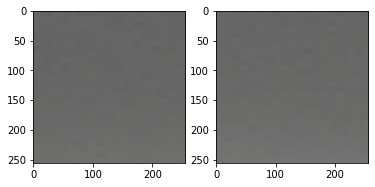

In [192]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(cropped_rgb_canonical[0,0].permute(1,2,0).cpu())
axarr[1].imshow(cropped_rgb_canonical[0,1].permute(1,2,0).cpu())